# Predicting Price of Airbnb Listings in NYC - Part 1



The following notebook showcases my analysis of AirBnB listings dataset originally posted on Kaggle by Dgomonov. The listings were scrapped on July 8th 2019 and are specific to NYC, NY.

Link to the dataset: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

The objective of the analysis is to:

- estimate listing price based on provided information
- derive additional useful and interesting insights


Part 1 deals with taking the existing dataset, performing data cleaning, feature engineering and running preliminary analysis. The product of this part is a data file for Machnie Learning analysis.

Part 2 - The Machine Learning part of the project applies machine learning algorithms to predict price of lisings based on various input variables. 

## Data Cleaning

Before applying any machine learning algorithms I will prepare the dataset by turning any potentially useful data into ML accessible format.

In [1]:
#import modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Open the data file and convert to a Data Frame
#Here I also separated randomly selected 20% of the data for later validation

data = pd.read_csv("AB_NYC_2019.csv")
#randomize the data
data.sample(frac=1)
df=data.copy()
df.shape

(48895, 16)

### Following are the dataset columns:

I grouped the columns into column categories for enhanced understanding of the dataset

#### Host descriptors:
- __host_id:__ host ID
- __host_name:__ name of the host
- __calculated_host_listings_count:__ amount of listing per host

#### Listing descriptors:
- __id:__ listing ID
- __name:__ name of the listing
- __room_type:__ listing space type
- __minimum_nights:__ amount of nights minimum
- __availability_365:__ number of days when listing is available for booking
- __price:__ price in dollars

#### Review descriptors:
- __number_of_reviews:__ number of reviews
- __last_review:__ latest review
- __reviews_per_month:__ number of reviews per month

#### Location descriptors:
- __neighbourhood_group:__ location
- __neighbourhood:__ area
- __latitude:__ latitude coordinates
- __longitude:__ longitude coordinates


### General approach

Prior to diving into the data it is worth to perform a thought experiment in which we ask ourselves what factors may be driving the lisiting prices for the given dataset, considering that the listings were most likely scrapped on July 8th 2019 (Monday), right after the Independence Day in New York City. 

I will also limit my analysis to lisitngs that are confined to 31 minimum nights at most, in order to exclude long term rentals. Therefore, my analysis will target short term renters, most likley vistors to the city, majority of whom may be tourists.

Here are a few items I brainstormed:
- neighborhood
- proximity to landmark objects
- proximity to public transportation (subways mostly)
- size of the dwelling (shared v. private v. apartment)
- prior reviews
- quality of the listing (ie. is the room pretty/tidy etc)

#### With that let's dive into data!

This is a snapshot of our data:

In [2]:
df.head().iloc[:,0:8]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399


In [3]:
df.head().iloc[:,8:]

,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Private room,149,1,9,2018-10-19,0.21,6,365
1,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Private room,150,3,0,NaN,NaN,1,365
3,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Taking care of dataset missing values
Replace missing values

- listings without reviews have missing values for last_review and reviews_per_month. For these lisitngs the missing values will be replaced by 0

- Some listings are missing a name or the host name is missing. These will be replaced with "None"

In [4]:
#fill missing values for last review and reviews per month with 0
df[["last_review", "reviews_per_month"]] = df[["last_review", "reviews_per_month"]].fillna(0)

#if there is no host name or listing name fill in None
df[["name", "host_name"]] = df[["name", "host_name"]].fillna("None")

#Drop rows were price of the listing is 0. We are not intersted in "free" 
#listings as they are most likely an error.
free = len(df[df.price == 0])
df = df[df.price != 0].copy()

#Print initial insights:
print("The initial dataset contained " + str(free)+ " listings with price of 0 USD, that had been removed")
print("There are " + str(len(df["id"].unique()))+" listings")
print("There are "+str(len(df.host_id.unique()))
      +" unique and indentifiable "+ "hosts.")
print("There are "+str(len(df[df["host_name"]=="None"]))
      +" unindentifiable "+ "hosts.")
print("Dataframe shape: "+str(df.shape))

The initial dataset contained 11 listings with price of 0 USD, that had been removed
There are 48884 listings
There are 37455 unique and indentifiable hosts.
There are 21 unindentifiable hosts.
Dataframe shape: (48884, 16)


inital analysis indicates that there are 11,492 more listings than hosts (identifiable and unidentifiable). This means that some hosts may list several properties. Let's verify that.


Each listing contains "Calculated_host_listings_count", which is a count of total listing by a specific host in the provided data. The logic below derives value of the calculated host listings count for a specific listing (36485609 in this example) and checks if it is equal to the total number of listings by that host (whose host ID is 30985759) in the dataset

The comparison yields true, meaning that "calculated_host_listings_count"  for the specific host indicated gives an accurate number of listings posted by the same host. Properties could then easily related by the host ID.

In [5]:
(len(df[df["host_id"]==30985759]) == df[df["id"]==36485609]["calculated_host_listings_count"]).tolist()

[True]

In [6]:
df[(df["calculated_host_listings_count"]>1)][["host_id","calculated_host_listings_count"]].sort_values(by=['host_id']).head(10)

,host_id,calculated_host_listings_count
0,2787,6
21556,2787,6
13963,2787,6
13583,2787,6
10372,2787,6
13688,2787,6
1,2845,2
22728,2845,2
8302,2881,2
7875,2881,2


#### Next, lets shift focus to the minimum nights 

Here I am plotting a histogram of minimum nights of rental required in the listing:

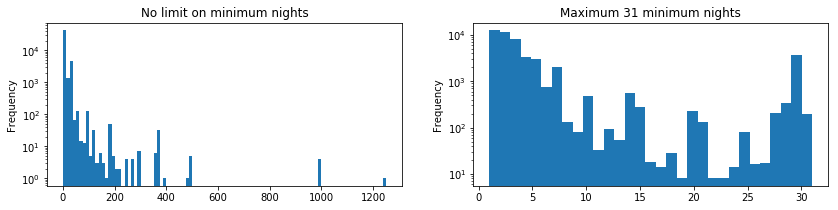

As a result of imposing minimum nights limit, 546 listings were removed.


In [7]:
df_old=df.copy()
df = df[df["minimum_nights"] <=31].copy()
removed_listings = len(df_old)-len(df)

fig = plt.figure(figsize=(14,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.hist(df_old.minimum_nights, bins=100, log=True)
ax1.set_ylabel("Frequency")
ax1.set_title("No limit on minimum nights")

ax2.hist(df.minimum_nights, bins=31, log=True)
ax2.set_ylabel("Frequency")
ax2.set_title("Maximum 31 minimum nights")

plt.show()

print("As a result of imposing minimum nights limit, " + str(removed_listings)+" listings were removed.")

Looking at the left-hand side histogram of minimum nights required to rent the property, there appears to be many listings targeted to rent for a minimum period of over 31 days.

As mentioned previously, in order to narrow the scope of this analysis I will focus on a potential tourist market, assuming that tourists will not want to stay longer than 31 days. Hence, I will remove any listings with required minimum nights greater than 31.

The updated distribution is plotted in the right-hand side histogram. It appears that the distribution is bimodal. There are two peaks of minimum nights. First peak maximizes at 1 night, while the other at 30 nights. This indicates, that the limit of 31 days that I set, captures renters interested in at least a month long rental period.

At this point there are no null values in the dataframe:

In [8]:
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Below is a statistical summary of the columns in the dataframe. We can conclude that:
- there are 38708 rows of data being considered
- all listings are between 40.499 and 40.913 latitude and -74.244 and -73.712 longitude squarely fitting into NYC's geographic location
- the listing price ranges between 10USD and 10,000USD with mean price of 149USD and standard deviation of 219USD suggesting a very broad price range distribution
- the minimum nights limit ranges betweeen 1 and 31 as determined above. It averages at 5.65, but as we have seen it is not normally distributed
- on average the listings are available 110 days per year. It would be interesting to understand if the listings are available in short intervals (such as weekends) or long intervals (several months at a time). Perhaphs this can be understood by looking at the correlation between minimum nights and availability.

In [9]:
df.describe().iloc[:,0:8]

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month
count,4.833800e+04,4.833800e+04,48338.000000,48338.000000,48338.000000,48338.000000,48338.000000,48338.000000
mean,1.903981e+07,6.783249e+07,40.728899,-73.952046,151.574682,5.684989,23.418387,1.100373
std,1.097445e+07,7.869342e+07,0.054547,0.046250,226.432123,8.347899,44.677596,1.602655
min,2.539000e+03,2.571000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000
25%,9.486255e+06,7.877355e+06,40.690020,-73.982980,69.000000,1.000000,1.000000,0.040000
50%,1.970095e+07,3.104202e+07,40.722985,-73.955630,106.000000,2.000000,5.000000,0.380000
75%,2.915869e+07,1.074344e+08,40.763120,-73.936120,175.000000,5.000000,24.000000,1.610000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,31.000000,629.000000,58.500000


In [10]:
df.describe().iloc[:,8:]

,calculated_host_listings_count,availability_365
count,48338.000000,48338.000000
mean,7.144731,112.099508
std,32.993670,131.357666
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,44.000000
75%,2.000000,225.000000
max,327.000000,365.000000


At this point we can also take a closer look into number based variables to see if any of them should be turned into categorical variables:

In [11]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

#### Let's start by looking at the distributions:

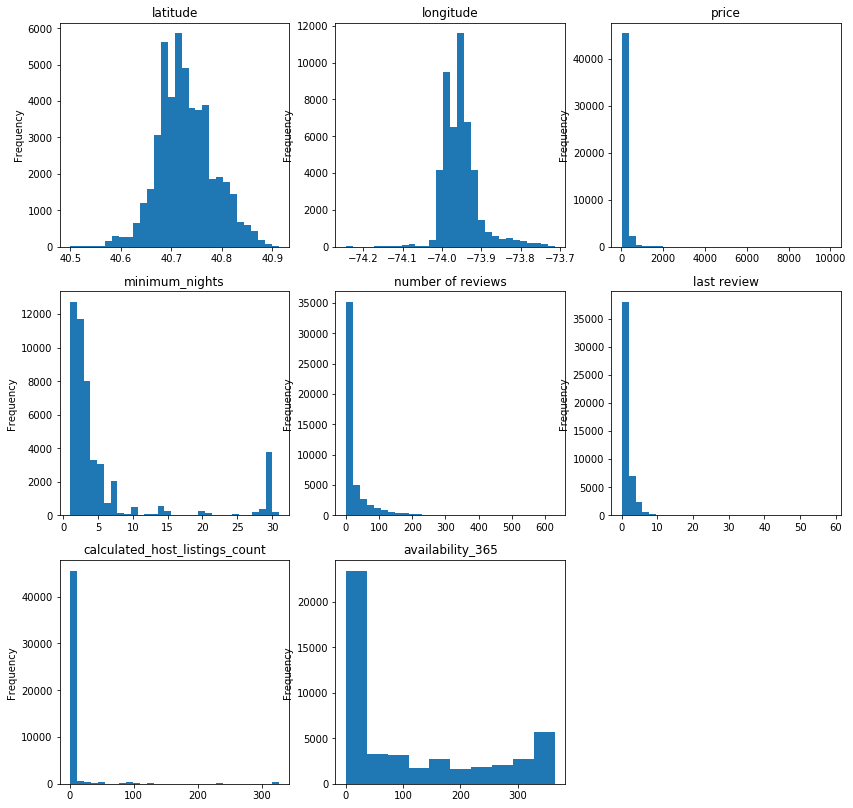

In [12]:
#separate out numerical variables
a=pd.DataFrame(df.dtypes.copy())
b= a[a[0] != 'object'].reset_index()
#drop id and host id:
numeric_vars=b["index"].tolist()[2:]

fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)

ax1.hist(df[numeric_vars[0]], bins=30)
ax1.set_ylabel("Frequency")
ax1.set_title(numeric_vars[0])

ax2.hist(df[numeric_vars[1]], bins=30)
ax2.set_ylabel("Frequency")
ax2.set_title(numeric_vars[1])

ax3.hist((df[numeric_vars[2]]), bins=30)
ax3.set_ylabel("Frequency")
ax3.set_title('price')

ax4.hist(df[numeric_vars[3]], bins=31)
ax4.set_ylabel("Frequency")
ax4.set_title(numeric_vars[3])

ax5.hist(df[numeric_vars[4]], bins=30)
ax5.set_ylabel("Frequency")
ax5.set_title("number of reviews")

ax6.hist(df[numeric_vars[5]], bins=30)
ax6.set_ylabel("Frequency")
ax6.set_title("last review")

ax7.hist(df[numeric_vars[6]], bins=30)
ax7.set_ylabel("Frequency")
ax7.set_title(numeric_vars[6])

ax8.hist(df[numeric_vars[7]])
ax8.set_ylabel("Frequency")
ax8.set_title(numeric_vars[7])
plt.show()

Looking at the distributions, clearly the following are heavily right skewed:
- price
- minimum_nights
- number of reviews
- last review
- calculated_host_lising_count

One way to reduce the skeweness is to logarithmically transform the distributions:

In [13]:
numeric_vars

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

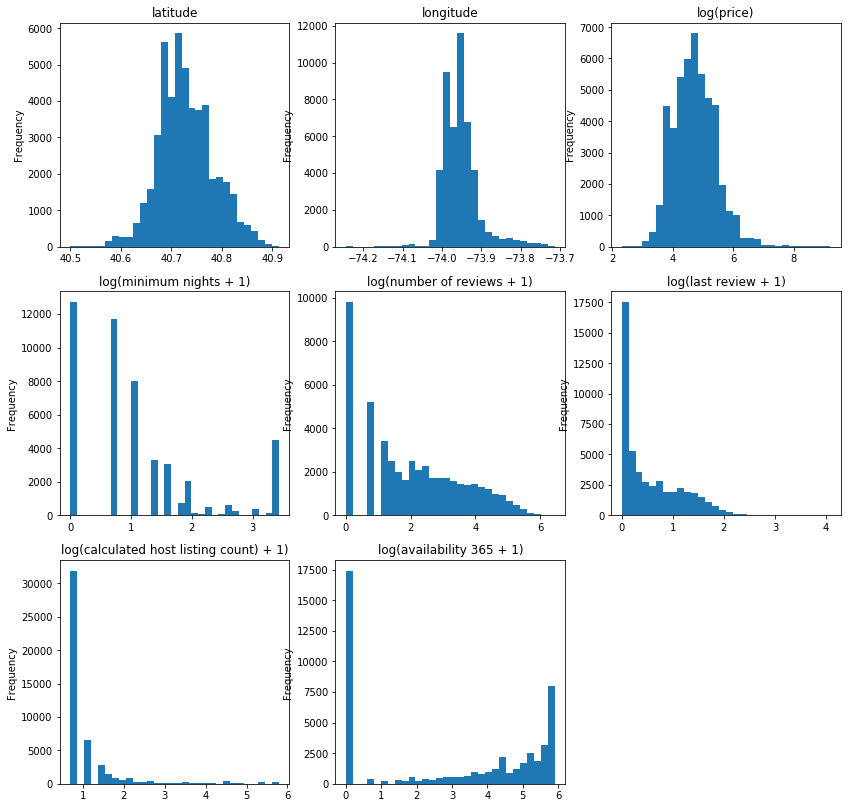

In [14]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)

ax1.hist(df[numeric_vars[0]], bins=30)
ax1.set_ylabel("Frequency")
ax1.set_title(numeric_vars[0])

ax2.hist(df[numeric_vars[1]], bins=30)
ax2.set_ylabel("Frequency")
ax2.set_title(numeric_vars[1])

ax3.hist(np.log((df[numeric_vars[2]])), bins=30)
ax3.set_ylabel("Frequency")
ax3.set_title('log(price)')

ax4.hist(np.log((df[numeric_vars[3]])), bins=31)
ax4.set_ylabel("Frequency")
ax4.set_title("log(minimum nights + 1)")

ax5.hist(np.log(df[numeric_vars[4]]+1), bins=30)
ax5.set_ylabel("Frequency")
ax5.set_title("log(number of reviews + 1)")

ax6.hist(np.log(df[numeric_vars[5]]+1), bins=30)
ax6.set_ylabel("Frequency")
ax6.set_title("log(last review + 1)")

ax7.hist(np.log(df[numeric_vars[6]]+1), bins=30)
ax7.set_ylabel("Frequency")
ax7.set_title("log(calculated host listing count) + 1)")

ax8.hist(np.log(df[numeric_vars[7]]+1), bins=30)
ax8.set_ylabel("Frequency")
ax8.set_title("log(availability 365 + 1)")

plt.show()

Transform the variables

In [15]:
for num in numeric_vars[3:]:
    df["log_("+num+" +1)"] = np.log(df[num]+1)
df["log_price"] = np.log(df.price)
df=df.drop(columns = numeric_vars[2:]).copy()

In [16]:
df.columns.tolist()

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'last_review',
 'log_(minimum_nights +1)',
 'log_(number_of_reviews +1)',
 'log_(reviews_per_month +1)',
 'log_(calculated_host_listings_count +1)',
 'log_(availability_365 +1)',
 'log_price']

In [17]:
df.shape

(48338, 16)

Note that logarithmic data transformation was used to smooth out the distributions. 

#### Let's see if any correlations between variables start to emerge:

In [18]:
numeric_vars = df.columns.tolist()[6:8]+df.columns.tolist()[10:]

In [19]:
numeric_vars

['latitude',
 'longitude',
 'log_(minimum_nights +1)',
 'log_(number_of_reviews +1)',
 'log_(reviews_per_month +1)',
 'log_(calculated_host_listings_count +1)',
 'log_(availability_365 +1)',
 'log_price']

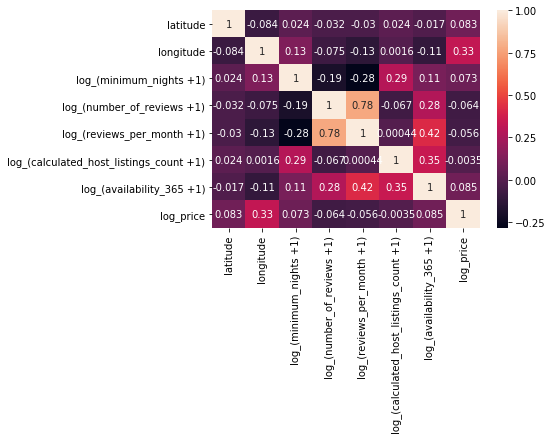

In [20]:
import seaborn as sns
x=df[numeric_vars].apply(lambda x: np.log(np.abs(x+1))).corr(method='pearson')
sns.heatmap(x, annot=True)
plt.show()

#### Observations on price:
- price seems to be positively correlated with longitude meaning that one can expect higher prices as position in NYC moves West. This is expected because Manhattan, which is the most expensive borough of the city, is located on the west side of the city
- latitude seems to have lesser effect on the price. However, there is a slight indication of higher prices located in the northern parts of the city
- price is also positively correlated with: increasing availability, the fact that the property is rented by a host who lists other properties, and increasing number of minimum nights
- price is negatively correlated with number of reviews and reviews per month, indicating that it is possible that the prior reviews could depress the prices to some extent

#### Other interesting observations:
- calculated host lisitng count is positively correlated with minimum nights and availability_365 indicating that hosts who list more than one property may be more strategic rather than opportunisitic about their rentals. That may attempt to maximize the amount of time a single renter stays at their property to minimize turnover cost. They also tend to maximize the amount of time the property is being rented.

#### Next let's turn the attention to non numerical variables

In [21]:
#separate out numerical variables
a=pd.DataFrame(df.dtypes.copy())
b= a[a[0] == 'object'].reset_index()
#drop id and host id:
non_num=b["index"].tolist()
print(non_num)

['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']


These belong to:

#### Host descriptors:
- __host_name:__ name of the host

#### Listing descriptors:
- __name:__ name of the listing
- __room_type:__ listing space type

#### Review descriptors:
- __last_review:__ latest review

#### Location descriptors:
- __neighbourhood_group:__ location
- __neighbourhood:__ area


We already know that location is an important price determinant. Hence let's dig a bit deeper to see how mean prices vary by neighborhood

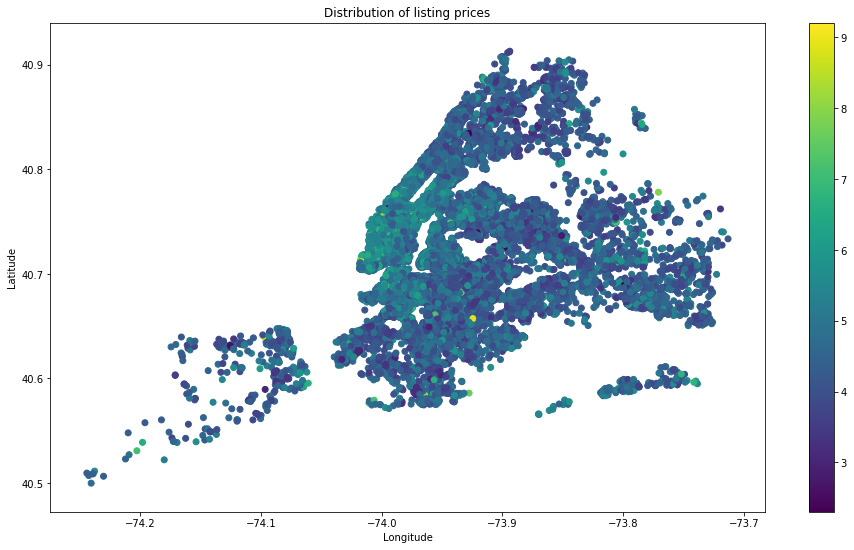

In [22]:
y = df.latitude
x = df.longitude
p = df.log_price
plt.figure(figsize=(16,9))
plt.scatter(x,y,c=p,cmap='viridis')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of listing prices")
plt.show()

The scatter plot above visualizes the geographical distribution of listings along with the relative pricing (increasing with brightening color).

High prices appear to be concentrated around Manhattan starting with neighborhoods around Central Park going south, as well as around portions of Brooklyn and Queens close to Manhattan.

Let's group the data by neighborhood, deriving mean pricing for each neighborhood:

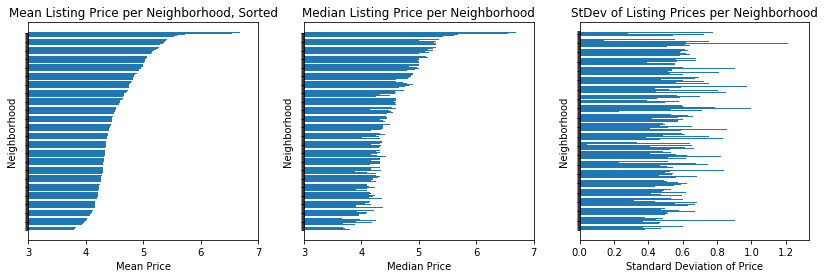

In [23]:
grouped = df.groupby("neighbourhood")
price_grouped = grouped["log_price"]
price = price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")


fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.barh(price.index,price["mean"])
ax1.set_yticklabels([])
ax1.set_ylabel("Neighborhood")
ax1.set_xlabel("Mean Price")
ax1.set_title("Mean Listing Price per Neighborhood, Sorted")
ax1.set_xlim(3,7)

ax2.barh(price.index,price["median"])
ax2.set_yticklabels([])
ax2.set_ylabel("Neighborhood")
ax2.set_xlabel("Median Price")
ax2.set_title("Median Listing Price per Neighborhood")
ax2.set_xlim(3,7)

ax3.barh(price.index,price["std"])
ax3.set_yticklabels([])
ax3.set_ylabel("Neighborhood")
ax3.set_xlabel("Standard Deviation of Price")
ax3.set_title("StDev of Listing Prices per Neighborhood")
plt.show()

Based on current findings it is worth to one-hot encode the neighborhood variable:

In [24]:
#One hot encoding
df = pd.concat([df, pd.get_dummies(df["neighbourhood"], drop_first=False)], axis=1)
#save neighborhoods into a list for further analysis:
neighborhoods = df.neighbourhood.values.tolist()
boroughs = df.neighbourhood_group.unique().tolist()
#drop the neighbourhood column from the database
df.drop(['neighbourhood'],axis=1, inplace=True)

In [25]:
df.shape

(48338, 236)

#### The next obvious variable to evaluate is Room type. This variable provides information about relative privacy that comes with the listing as well as its size

In [26]:
grouped = df.groupby("room_type")
room_type_price_grouped = grouped["log_price"]
room_type_price = room_type_price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
room_type_price

,mean,median,amax,std
room_type,,,,
Shared room,3.954147,3.806662,7.495542,0.651180
Private room,4.295073,4.248495,8.922658,0.510161
Entire home/apt,5.142397,5.075174,9.210340,0.564829


### Extreme Outliers
- The data most likely includes extreme outliers, which will be difficult to model. 
- The following code will remove extreme outliers by borough.
- An outlier is defined as 3 x IQR below 25th quantile and above 75th quantile
- The code will also treat each room type differently to avoid data bias

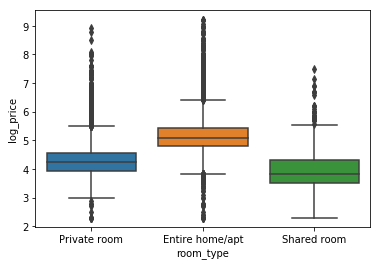

In [27]:
sns.boxplot(x="room_type",y="log_price", data=df)
plt.show()

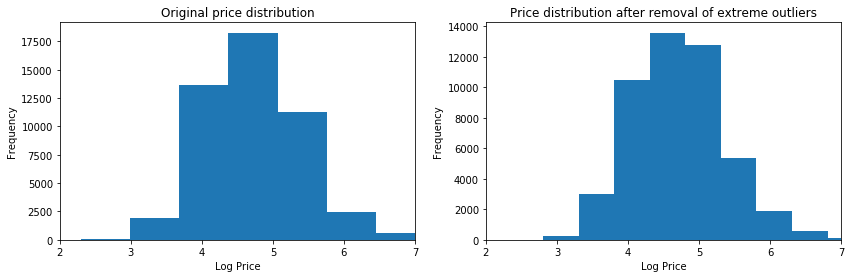

As a result of oulier removal 312 rows of data were removed.


In [28]:
def removal_of_outliers(df,room_t, nhood, distance):
    '''Function removes outliers that are above 3rd quartile and below 1st quartile'''
    '''The exact cutoff distance above and below can be adjusted'''

    new_piece = df[(df["room_type"]==room_t)&(df["neighbourhood_group"]==nhood)]["log_price"]
    #defining quartiles and interquartile range
    q1 = new_piece.quantile(0.25)
    q3 = new_piece.quantile(0.75)
    IQR=q3-q1

    trimmed = df[(df.room_type==room_t)&(df["neighbourhood_group"]==nhood) &(df.log_price>(q1-distance*IQR))&(df.log_price<(q3+distance*IQR))]
    return trimmed

#apply the function
df_private = pd.DataFrame()
for neighborhood in boroughs:
    a = removal_of_outliers(df, "Private room",neighborhood,3)
    df_private = df_private.append(a)

df_shared = pd.DataFrame()
for neighborhood in boroughs:
    a = removal_of_outliers(df, "Shared room",neighborhood,3)
    df_shared = df_shared.append(a)
    
df_apt = pd.DataFrame()
for neighborhood in boroughs:
    a = removal_of_outliers(df, "Entire home/apt",neighborhood,3)
    df_apt = df_apt.append(a)
    
# Create new dataframe to absorb newly produced data    
df_old=df.copy()    
df = pd.DataFrame()
df = df.append([df_private,df_shared,df_apt])

#plot the results
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(df_old.log_price)
ax1.set_xlim(2,7)
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Log Price")
ax1.set_title("Original price distribution")

ax2.hist(df.log_price)
ax2.set_xlim(2,7)
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Log Price")
ax2.set_title("Price distribution after removal of extreme outliers")
plt.show()

print("As a result of oulier removal " + str(df_old.shape[0]-df.shape[0]) + " rows of data were removed.")

In [29]:
df.shape

(48026, 236)

In [30]:
grouped = df.groupby("room_type")
room_type_price_grouped = grouped["log_price"]
room_type_price = room_type_price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
room_type_price

,mean,median,amax,std
room_type,,,,
Shared room,3.925321,3.806662,6.214608,0.592874
Private room,4.279373,4.248495,6.484635,0.467583
Entire home/apt,5.130023,5.075174,7.311218,0.527369


#### Further analysis

In [31]:
#convert room types to dummies
df = pd.concat([df, pd.get_dummies(df["room_type"], drop_first=False)], axis=1)
df.drop(['room_type'],axis=1, inplace=True)

In [32]:
df.shape

(48026, 238)

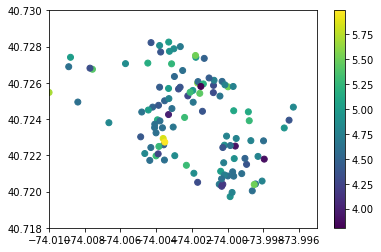

In [33]:
y = df[(df["SoHo"]==1) & (df["Private room"]==1)].latitude
x = df[(df["SoHo"]==1) & (df["Private room"]==1)].longitude
p = df[(df["SoHo"]==1) & (df["Private room"]==1)].log_price
plt.scatter(x,y,c=p,cmap='viridis')
plt.xlim(-74.01,-73.995)
plt.ylim(40.718,40.73)
plt.colorbar()
plt.show()

####  Last review is a data when last review has been posted. Perhaps the most effective way of dealing with this variable is to
- covert it to number of days since last review counting down from the data the data was scraped off the web
- categorize

In [34]:
import datetime as dt
#convert object to datetime:
df["last_review"] = pd.to_datetime(df["last_review"])
#Check the latest review date in the datebase:
print(df["last_review"].max())

2019-07-08 00:00:00


In [35]:
df.shape

(48026, 238)

The last review in the database dates to July 8th 2019, which will be used as time zero for analysis:

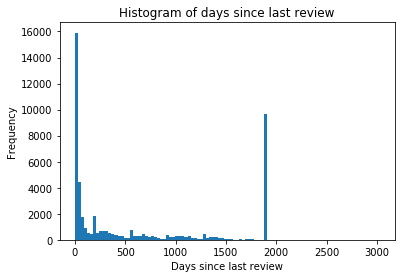

In [36]:
df["last_review"]=df["last_review"].apply(lambda x: dt.datetime(2019,7,8)-x)
df["last_review"]=df["last_review"].dt.days.astype("int").replace(18085, 1900)
plt.hist(df["last_review"], bins=100)
plt.ylabel("Frequency")
plt.xlabel("Days since last review")
plt.ylabel("Frequency")
plt.title("Histogram of days since last review")
plt.show()

Replace with the following categories for simplification:
- last month
- last 6 months
- last year
- last 5 years
- never

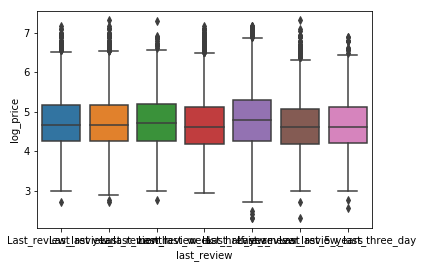

In [37]:
def date_replacement(date):
    if date <=3:
        return "Last_review_last_three_day"
    elif date <= 7:
        return "Last_review_last_week"
    elif date <= 30:
        return "Last_review_last_month"
    elif date <= 183:
        return "Last_review_last_half_year"
    elif date <= 365:
        return "Last_review_last year"
    elif date <= 1825:
        return "Last_review_last_5_years"
    else:
        return "Last_review_never" 

    
df["last_review"]=df["last_review"].apply(lambda x: date_replacement(x))
sns.boxplot(x="last_review", y=df.log_price, data=df)
plt.show()

Time since last review does not show any clear trend on the sale of entire dataset. Yet it may be important to keep the categorical values included for later machine learning experiments.

In [38]:
grouped = df.groupby("last_review")
last_review_price_grouped = grouped["log_price"]
last_review_price = last_review_price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
last_review_price

,mean,median,amax,std
last_review,,,,
Last_review_last_5_years,4.649034,4.605170,7.309881,0.613510
Last_review_last_half_year,4.664274,4.605170,7.166266,0.668865
Last_review_last_three_day,4.692818,4.605170,6.902743,0.639020
Last_review_last year,4.709821,4.653960,7.170120,0.647545
Last_review_last_month,4.716536,4.663439,7.311218,0.644853
Last_review_last_week,4.738867,4.700480,7.296413,0.657426
Last_review_never,4.805883,4.787492,7.181592,0.737317


In [39]:
#convert last review to dummies
df = pd.concat([df, pd.get_dummies(df["last_review"], drop_first=False)], axis=1)
df.drop(["last_review"],axis=1, inplace=True)

There is no readily apparent trend of recency of reviews with respect to room price visible. Further analysis may reveal more insight.

#### Natural Language Processing

In [40]:
#import necessary libraries
import nltk
import os
import nltk.corpus
from nltk import ne_chunk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sepuchal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sepuchal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sepuchal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\sepuchal\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sepuchal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [41]:
#initiate stopwords
a = set(stopwords.words('english'))
#obtain text
text = df["name"].iloc[10]
#tokenize text
text1 = word_tokenize(text.lower())
#create a list free of stopwords
no_stopwords = [x for x in text1 if x not in a]
#lemmatize the words
lemmatizer = WordNetLemmatizer() 
lemmatized = [lemmatizer.lemmatize(x) for x in no_stopwords]

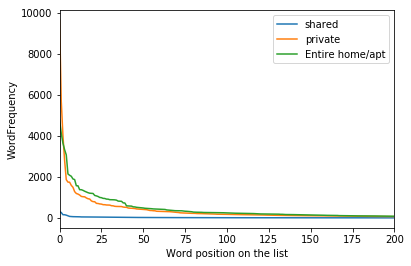

In [42]:
def unique_words1(dwelling):

    apt = df[df[dwelling]==1]["name"]
    a = set(stopwords.words('english'))
    words = []
    # append each to a list
    for lis in range(0, len(apt)):
        listing = apt.reset_index().iloc[lis,1]
        #tokenize text
        text1 = word_tokenize(listing.lower())
        #create a list free of stopwords
        no_stopwords = [x for x in text1 if x not in a]
        #lemmatize the words
        lemmatized = [lemmatizer.lemmatize(x) for x in no_stopwords]
        no_punctuation = [x.translate(str.maketrans('','',string.punctuation)) for x in lemmatized]
        no_digits = [x.translate(str.maketrans('','',"0123456789")) for x in no_punctuation ]
        for item in no_digits:
            words.append(item)


    #create a dictionary
    unique={}
    for word in words:
        if word in unique:
            unique[word] +=1
        else:
            unique[word] = 1

    #sort the dictionary
    a=[]
    b=[]

    for key, value in unique.items():
        a.append(key)
        b.append(value)

    aa=pd.Series(a)
    bb=pd.Series(b)    

    comb=pd.concat([aa,bb],axis=1).sort_values(by=1, ascending=False).copy()

    return comb

#apply the function
private = unique_words1("Private room")
home = unique_words1("Entire home/apt")
shared = unique_words1("Shared room")

words_private = private.iloc[1:,1]
words_home = home.iloc[1:,1] 
words_shared = shared.iloc[1:,1] 

#plot the results
plt.plot(words_shared.reset_index()[1], label="shared")
plt.plot(words_private.reset_index()[1], label ="private")
plt.plot(words_home.reset_index()[1], label="Entire home/apt")
plt.xlim(0,200)
plt.ylabel("WordFrequency")
plt.xlabel("Word position on the list")
plt.legend()
plt.show()


In [43]:
home_new = home.reset_index().iloc[1:50,1:3].copy()
private_new = private.reset_index().iloc[1:50,1:3].copy()
shared_new = shared.reset_index().iloc[1:50,1:3].copy()

all_words = pd.concat([home_new, private_new, shared_new], axis=1, sort=False)
all_words

,0,1,0,1,0,1
1,apartment,4767,room,9627,room,314
2,bedroom,4124,private,5699,shared,262
3,studio,3644,bedroom,4010,cozy,158
4,apt,3326,cozy,2812,bed,156
5,br,3070,brooklyn,1863,manhattan,135
6,brooklyn,2141,manhattan,1744,apartment,104
7,spacious,2078,apartment,1740,brooklyn,74
8,cozy,2029,spacious,1585,space,67
9,east,1897,sunny,1494,near,62
10,park,1869,williamsburg,1281,apt,61


In [44]:
#see how many listing there are for each type of room:
print("Numer of shared room listings: "+str(len(df[df["Shared room"]==1])))
print("Numer of private room listings: "+str(len(df[df["Private room"]==1])))
print("Numer of entire home/apt listings: "+str(len(df[df["Entire home/apt"]==1])))

Numer of shared room listings: 1132
Numer of private room listings: 21977
Numer of entire home/apt listings: 24917


In [45]:
#Create a list of the most popular words common for all room types:
most_popular_words = home_new.iloc[:,0].tolist()+private_new.iloc[:,0].tolist()+shared_new.iloc[:,0].tolist()
most_popular = pd.Series(most_popular_words)
popular_descriptors=most_popular.unique().tolist()

In [46]:
def unique_words2(name, word):
    '''This function takes individual name and looks for a matching word in it'''
    a = set(stopwords.words('english'))
    #tokenize the name
    text1 = word_tokenize(str(name).lower())
    #create a list free of stopwords
    no_stopwords = [x for x in text1 if x not in a]
    #lemmatize the words
    lemmatized = [lemmatizer.lemmatize(x) for x in no_stopwords]
    no_punctuation = [x.translate(str.maketrans('','',string.punctuation)) for x in lemmatized]
    no_digits = [x.translate(str.maketrans('','',"0123456789")) for x in no_punctuation ]
    counter = 0
    for item in no_digits:
        if str(item) == str(word):
            counter += 1
        else:
            continue

    if counter != 0:
        return 1
    else:
        return 0
    
#Apply the function 
for item in popular_descriptors:
    df[item]= df["name"].apply(lambda x: unique_words2(x,item))

In [47]:
#convert last review to dummies
df = pd.concat([df, pd.get_dummies(df['neighbourhood_group'], drop_first=False)], axis=1)
df.drop(['neighbourhood_group'],axis=1, inplace=True)

In [48]:
#drop unnecessary columns
df = df.drop(['id','name','host_id','host_name'], axis=1).copy()
df.shape

(48026, 321)

In [49]:
len(popular_descriptors)

77

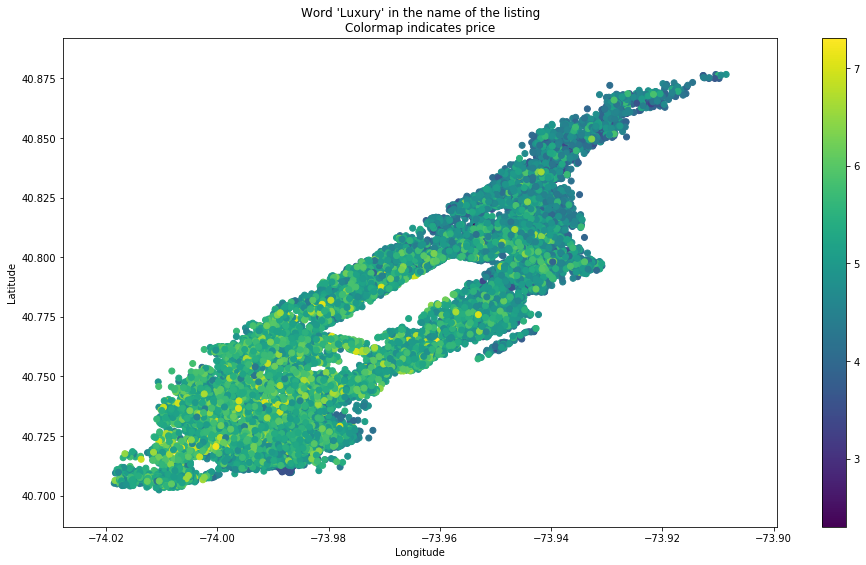

In [50]:
def plot_by_word(word):
    '''creates a plot of price for listings matching given word'''
    y = df[(df[word]==1)].latitude
    x = df[(df[word]==1)].longitude
    p = df[(df[word]==1)].log_price
    plt.figure(figsize=(16,9))
    plt.scatter(x,y,c=p,cmap='viridis')
    plt.xlabel
    plt.colorbar()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Word 'Luxury' in the name of the listing\nColormap indicates price")
    plt.show()
    
plot_by_word("Manhattan")

In [51]:
#export dataframe to csv:
df.to_csv("processed_df_airbnb.csv")

### Proceed to Machine Learning